# Baseline 2:

Staged Least Squares Instrumental Variables Regression using Cornelia's Medical Data

- Using instrumental variables and fixed effects shown here: https://docs.google.com/spreadsheets/d/1_MMYeQuxiov2OLE5AX0CE9R1T1mBrk7vpozy2fGjNBg/edit?usp=sharing
- Include control diagnoses.

---
### Step 1: Import packages

In [1]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS
from statsmodels.stats.anova import anova_lm

import patsy
import sklearn.preprocessing as sklp
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

---
### Step 2: Define working directories and global variables

#### Hi Cornelia! Please have the following directories created ahead of time (data/ and output/ are your original ones; the remaining folders will be used to store the model outputs and relevant metadata we need to associate models to our instrument-and-FEs combinations). Thank you!
* data/
* output/
* models_s1/
* models_s2/
* fixed_effects/

#### 2.1. Set working directories

In [2]:
in_dir_sc = 'C:/Users/cilin/Research/CA_hospitals_capstone/data/'
in_dir_h = 'C:/Users/cilin/Research/CA_hospitals_capstone/output/'
# folder containing stage 1 outputs
out_dir1 = 'C:/Users/cilin/Research/CA_hospitals_capstone/models_s1/'
# folder containing stage 2 outputs
out_dir2 = 'C:/Users/cilin/Research/CA_hospitals_capstone/models_s2/'
# folder containing csvs documenting which fixed effects are in which csv files
out_dir3 = 'C:/Users/cilin/Research/CA_hospitals_capstone/fixed_effects/'



# #Michelle testing on her computer
# in_dir_sc = '/Users/michelle/MIDS/210 Capstone/data/'
# in_dir_h = '/Users/michelle/MIDS/210 Capstone/output/'

# # folder containing stage 1 outputs
# out_dir1 = '/Users/michelle/MIDS/210 Capstone/models_s1/'

# # folder containing stage 2 outputs
# out_dir2 = '/Users/michelle/MIDS/210 Capstone/models_s2/'

# # folder containing csvs documenting which fixed effects are in which csv files
# out_dir3 = '/Users/michelle/MIDS/210 Capstone/fixed_effects/'

#### 2.2. Set Instrumental Variable (predictor), Fixed Effects set, and Notebook Index
* Set the instrumental variable (predictor), fixed effects set, and unique notebook index (please don't change)

In [3]:
# set instrumental variable version
predictor = 'Izmy_v3_normed_D_and_TPY'
# predictor = 'Izmy_v4_nodist_normed_TPY'
#predictor = 'Izmy_v5_all_normed_but_wspd_ratio'
#predictor = 'Izmy_v7_all_normed_no_wspd'

# set FE to one of 8 sets (int)
FE_set_num = 4

# sets unique notebooks index (string - this is just to output a csv file name)
notebook_index = "diff04_fn_T"

# set option to filter outliers on medical outcomes data
filter_medical_outliers = False

#### 2.3. Specify which inputs and outputs we're looking at
* Specify the pm2.5 (target) name 
* Specify instrument (predictor) name
* Specify lead and lag times

In [4]:
lead_time = 9
lag_time = '3'
lag_style = 'fwd'

# define lead time for IV: 'last_month', 'r6', 'r9', 'r12'
IV_lead = "r" + str(lead_time)
HO_lag = lag_style + str(lag_time)

if IV_lead:
    IV_lead_input = "_" + IV_lead 
else:
    # don't add underscore if empty string
    IV_lead_input = IV_lead

# define lag time for Health Outcome: '', 'fwd3', 'cent3', 'fwd6', 'cent6', 'fwd12', 'cent12'
if HO_lag:
    HO_lag_input = "_" + HO_lag
else:
    # don't add underscore if empty string
    HO_lag_input = HO_lag

# IV options: 1 month, 6 months, 9 months, 12 months
IV_window_col = [f'pm25{IV_lead_input}']

# health outcome options (fwd or cent): 1 month, 3 months, 6 months, 12 months
health_outcome_window_col = [f'y_injuries{HO_lag_input}']

filter_cols = IV_window_col + health_outcome_window_col # columns to filter out at the beginning and end of df, before modeling

target_name_s1 = f'pm25{IV_lead_input}'
predictor_name_s1 = f'{predictor}{IV_lead_input}'

print(f"Stage 1\nTarget Name (target_name_s1) = {target_name_s1}\nPredictor Name (predictor_name_s1) = {predictor_name_s1}")
print(f"\nStage 2\nHealth Outcome Lag Input (HO_lag_input) = {HO_lag_input}")

Stage 1
Target Name (target_name_s1) = pm25_r9
Predictor Name (predictor_name_s1) = Izmy_v3_normed_D_and_TPY_r9

Stage 2
Health Outcome Lag Input (HO_lag_input) = _fwd3


#### 2.4. Define fixed effects
* Define Fixed Effects based on the fixed effects set hardcoded in 2.2.

In [5]:
basics = " ~ county + month + year_trend * C(county_month)"
env = '+ avg_temp' + IV_lead_input + ' + avg_elevation_diff_m'

if FE_set_num == 1:
    # FE Set 1
    adds = ""
elif FE_set_num == 2:
    # FE Set 2
    adds = ' + ca_agi_per_returns + total_population'
elif FE_set_num == 3:
    # FE Set 3
    adds = ' + school_count + total_population'
elif FE_set_num == 4:
    # FE Set 4
    adds = ' + total_population + avg_count_ps_within_5km'
elif FE_set_num == 5:
    # FE Set 5
    adds = ' + ca_agi_per_returns'
elif FE_set_num == 6:
    # FE Set 6
    adds = ' + total_population'
elif FE_set_num == 7:
    # FE Set 7
    adds = ' + ca_agi_per_returns + total_population + avg_wspd_top_15_r' + str(lead_time)
elif FE_set_num == 8:
    # FE Set 8
    adds = ''
    env = ''

fixed_effects = basics + env + adds

print("basics:\n{}\n".format(basics))
print("env:\n{}\n".format(env))

print("Fixed effects are:\n{}".format(fixed_effects))

basics:
 ~ county + month + year_trend * C(county_month)

env:
+ avg_temp_r9 + avg_elevation_diff_m

Fixed effects are:
 ~ county + month + year_trend * C(county_month)+ avg_temp_r9 + avg_elevation_diff_m + total_population + avg_count_ps_within_5km


---
### Step 3: Define functions

In [6]:
def fit_ols(df, outcome, predictor, fixed_effects):
    ''''''
    # drop if outcome is nan
    temp = df[~df[outcome].isna()]
    temp.reset_index(drop=True, inplace=True)

    # create FE and interactions between FE and continous vars
    f = outcome + fixed_effects
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    # X = temp[['pm25']]
    X = temp[[predictor]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    model_a = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    # display estimates
    print('Outcome: ', outcome)
    print('-------------------------------------')
    display(pd.concat(
        [
            
            pd.DataFrame(model_a.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(model_a.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            model_a.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:],
            pd.DataFrame(model_a.pvalues.values).reset_index(drop=True).rename(columns={0:"p-value"}).iloc[0:2,:]
        ],
        axis=1
    ))

In [7]:
def fit_1st_stage(df, pm_col, instr_col, fixed_effects):
    ''' First stage to check whether wfeI is a strong instrument for pm25I
    '''
    
    temp = df.copy()

    # create FE and interactions between FE and continous vars
    f = pm_col + fixed_effects
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    X = temp[[instr_col]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    fit_1st_stage = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    # display estimates
    print('Outcome: ', pm_col)
    print('-------------------------------------')
    display(pd.concat(
        [
            pd.DataFrame(fit_1st_stage.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(fit_1st_stage.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            fit_1st_stage.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:],
            pd.DataFrame(fit_1st_stage.pvalues.values).reset_index(drop=True).rename(columns={0:"p-value"}).iloc[0:2,:]
        ],
        axis=1
    ))
    
    # save pm25I_hat
    temp[pm_col+'_hat'] = fit_1st_stage.get_prediction(X).summary_frame()['mean']
    
    # save model
    results_label = "s1_" + notebook_index + "_PREDICTOR_" + instr_col +  "_FE_SET_" + str(FE_set_num) + "_TARGETING_" + pm_col + "_LAG" + HO_lag_input + ".pkl"
    filename = os.path.join(out_dir1, results_label)
    fit_1st_stage.save(filename, remove_data=True)

    return temp

In [8]:
def fit_2sls(df, outcome, independent_var_name, fixed_effects):
    ''''''
    #independent_var_name example: 'pm25_hat'

    # drop if outcome is nan
    temp = df[~df[outcome].isna()]
    temp.reset_index(drop=True, inplace=True)

    # optional code to filter outliers
    if filter_medical_outliers:
        # print(f"Outcome: {outcome}")
        # display(temp[outcome].describe())
        old_row_count = temp.shape[0]

        #temp = temp[ np.abs(temp[outcome]-temp[outcome].mean()) <= min(3*temp[outcome].std(), 1000*int(lag_time)) ]
        temp = temp[ np.abs(temp[outcome]-temp[outcome].mean()) <= (3*temp[outcome].std()) ]
        new_row_count = temp.shape[0]
        print(f"Outliers (over 3 std away) were filtered out, We drop {old_row_count - new_row_count} rows.")
        #display(temp[outcome].describe())

    # create FE and interactions between FE and continous vars
    f = outcome + fixed_effects #" ~ county + month + year_trend * C(county_month)"
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    #X = temp[['pm25_hat']]
    X = temp[[independent_var_name]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    model_a = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    # display estimates
    print('Outcome: ', outcome)
    print('-------------------------------------')
    display(pd.concat(
        [
            pd.DataFrame(model_a.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(model_a.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            model_a.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:],
            pd.DataFrame(model_a.pvalues.values).reset_index(drop=True).rename(columns={0:"p-value"}).iloc[0:2,:]
        ],
        axis=1
    ))

    # save outcome_hat
    temp[outcome+'_hat'] = model_a.get_prediction(X).summary_frame()['mean']

    # save model
    results_label = "s2_" + notebook_index + "_INSTRUMENT_" + predictor_name_s1 + "_FE_SET_" + str(FE_set_num) + "_TARGETING_" + outcome + ".pkl"
    filename = os.path.join(out_dir2, results_label)
    model_a.save(filename, remove_data=True)

    return temp

---
### Step 4: Read and clean individual datasets

#### 4.1. Define the function to generate LEAD rolling windows on dataframe

In [9]:
def roll_selected_cols(df, cols_to_roll:list = ['Izmy_v1_unnormed'\
    ,'Izmy_v2_nodist_unnormed' \
    ,'Izmy_v3_normed_D_and_TPY' \
    ,'Izmy_v4_nodist_normed_TPY' \
    ,'Izmy_v5_all_normed']
    ,rolling_periods:list = [6]):

    """Generates rolling averages for the input variables over the input time periods.
    Inputs: df (pd dataframe): contains the data on a y-m level
            cols_to_roll (list): list of columns to generate rolling avgs--must be in df
            rolling_periods (list): list of time windows (in months) to roll over
            
    Outputs: df: Pandas dataframe containing the new columns
             all_cols: list of list containing the new columns, separated by input type"""
    
    df_int = df.copy().sort_values(['school_zip', 'year_month'])
    
    all_cols_int = []

    # Roll each variable
    for col_index in range(len(cols_to_roll)):
        new_cols = []

        col_to_roll = cols_to_roll[col_index]
        rolling_periods = rolling_periods

        for period in rolling_periods:
            df_int[f'{col_to_roll}_r{period}'] = df_int.groupby('school_zip')[col_to_roll]\
                .apply(lambda x: x.rolling(window=period, min_periods=period, closed='left').mean())
            
            new_cols.append(col_to_roll + "_r" + str(period))

        all_cols_int.append([col_to_roll] + new_cols)
        
    return df_int, all_cols_int



#### 4.2. Read in non-medical data and medical data
* Make sure the .csv name starts with 'modeling'
* Generate rolling windows for non-medical data for instrumental variable
* Filter out 2018 data from both non-medica and medical data

In [10]:
# non-medical data
for file in os.listdir(in_dir_sc):
    if file.startswith('modeling'):
        # read in our modeling data
        df_sc = pd.read_csv(os.path.join(in_dir_sc, file))

# add key to df
df_sc['patzip_year_month'] = df_sc.school_zip.astype(str) + '-' + df_sc.year.astype(str) + '-' + df_sc.month.astype(str)

# add instrumental variables rolling things here - looking at past data, so need 2000-2002 for previous avgs
cols_to_roll = [predictor,'avg_wspd_top_15','avg_temp']

rolling_periods = [lead_time]
df_sc, all_cols = roll_selected_cols(df=df_sc, cols_to_roll=cols_to_roll, rolling_periods=rolling_periods)

# drop if year >=2018
df_sc = df_sc[df_sc.year.le(2017)]

# print shape of data
print('Shape of data ', df_sc.shape)
df_sc.head(2)



Shape of data  (294897, 153)


,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v3_normed_D_and_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.272222,0.011111,90001-2000-1,NaN,NaN,NaN
1322,1322,1322,2000-02-01,90001,Los Angeles,Los Angeles County,13.666667,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320

In [11]:
# medical data
df_h = pd.DataFrame()
df_h['patzip_year_month'] = df_sc.patzip_year_month.unique()

for file in os.listdir(in_dir_h):
    # read in cornelia's healthcare data
    temp = pd.read_csv(os.path.join(in_dir_h, file)).iloc[:,1:]
    # rename number_of_visits column
    temp.rename(
        columns={'number_of_visits':'visits_'+file.split('.')[0]},
        inplace=True
    )

    # merge to df_h
    df_h = df_h.merge(
        temp[['patzip_year_month', 'visits_'+file.split('.')[0]]],
        on='patzip_year_month',
        how='left'
    )

# Filter out 2018 data bc it's all nulls 
# if year > 2017, drop
df_h['year_h'] = df_h.patzip_year_month.str.split('-').str[1]
df_h = df_h[df_h.year_h.le('2017')]
df_h.drop(columns='year_h', inplace=True)

# print shape of data
print('Shape of data ', df_h.shape)

Shape of data  (294897, 11)


In [12]:
df_h.columns

Index(['patzip_year_month', 'visits_all_malignant_cancers',
       'visits_all_nonblood_malignant_cancers', 'visits_blood_diseases',
       'visits_blood_or_bv_diseases', 'visits_blood_vessel_diseases',
       'visits_cardioresp_cancers', 'visits_hematopoietic_cancers',
       'visits_injuries', 'visits_respiratory', 'visits_type_1_diabetes'],
      dtype='object')

#### 4.3. Dynamically add 'y_' and lag times to the column names

In [13]:
# Get the list of outcome columns from the merged health dataset (df_h above)
num_visits_col_names = [i for i in list(df_h.columns) if 'visit' in i]
print("num_visits_col_names:\n{}\n".format(num_visits_col_names))

# y_col_names is used in Section 5.4.
y_col_names = ['y_' + i for i in num_visits_col_names]
print("y_col_names:\n{}\n".format(y_col_names))

# create a list of columns for outcome variables with health outcome lag window added
# y_col_names_lag is used in Step 7
y_col_names_lag = []
for i in y_col_names:
    new_name = i + HO_lag_input
    y_col_names_lag.append(new_name)

print("y_col_names_lag:\n{}".format(y_col_names_lag))

# create a list of columns for outcome variables with health outcome lag window added
y_col_names_lag_diff = []
for i in y_col_names_lag:
    new_name = i + '_diff_r12'
    y_col_names_lag_diff.append(new_name)

print("\ny_col_names_lag_diff:\n{}".format(y_col_names_lag_diff))

num_visits_col_names:
['visits_all_malignant_cancers', 'visits_all_nonblood_malignant_cancers', 'visits_blood_diseases', 'visits_blood_or_bv_diseases', 'visits_blood_vessel_diseases', 'visits_cardioresp_cancers', 'visits_hematopoietic_cancers', 'visits_injuries', 'visits_respiratory', 'visits_type_1_diabetes']

y_col_names:
['y_visits_all_malignant_cancers', 'y_visits_all_nonblood_malignant_cancers', 'y_visits_blood_diseases', 'y_visits_blood_or_bv_diseases', 'y_visits_blood_vessel_diseases', 'y_visits_cardioresp_cancers', 'y_visits_hematopoietic_cancers', 'y_visits_injuries', 'y_visits_respiratory', 'y_visits_type_1_diabetes']

y_col_names_lag:
['y_visits_all_malignant_cancers_fwd3', 'y_visits_all_nonblood_malignant_cancers_fwd3', 'y_visits_blood_diseases_fwd3', 'y_visits_blood_or_bv_diseases_fwd3', 'y_visits_blood_vessel_diseases_fwd3', 'y_visits_cardioresp_cancers_fwd3', 'y_visits_hematopoietic_cancers_fwd3', 'y_visits_injuries_fwd3', 'y_visits_respiratory_fwd3', 'y_visits_type_1_di

---
### Step 5: Merge datasets and data preprocessing

#### 5.1. Merge non-medical and medical datasets

In [14]:
# merge df_h to df_sc
df_all = df_sc.merge(
    df_h,
    on='patzip_year_month',
    how='left'
)

# print shape of data
print('Shape of data ', df_all.shape)
df_all.head(2)

# Shape of data  (294897, 164) <-- old one

Shape of data  (294897, 163)


,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v3_normed_D_and_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_all_malignant_cancers,visits_all_nonblood_malignant_cancers,visits_blood_diseases,visits_blood_or_bv_diseases,visits_blood_vessel_diseases,visits_cardioresp_cancers,visits_hematopoietic_cancers,visits_injuries,visits_respiratory,visits_type_1_diabetes
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

#### 5.2. Fill in nulls conditionally on merged datasets

* For each health outcome, fill in the nulls for a zipcode with 0's ONLY if that row occurred after the first non-zero/not-null visit in that zipcode for that health outcome (keeps them as nulls otherwise)

In [15]:
def filter_nans(df, visits_cols = num_visits_col_names, replace_after_1 = True):
    """Function to generate columns in place that do one of two things
    
    If replace_after_1 == True, replacec NaNs with 0's only if that 
    row occurred after the first non-zero/not null visit in that zipcode for the specific
    health outcome. Keeps them as nulls otherwise.
    
    If replace_after_1 == False, replaces all NaNs with 0's if there exists any
    non-zero/not null visit in that zipcode for the specific health outcome. Keeps
    them as nulls otherwise.

    Args:
        df (DataFrame): Input dataframe
        visits_cols (list, optional): list of columns to selectively filter NaNs
        replace_after_1: Bool
    Returns:
        DataFrame with columns replaced with their NaN-filtered versions
    """

    def get_rowIndex(row):
        """Function intended for applying across df rows

        Args:
            row (int): row

        Returns:
            int: index of row
        """
      
        return row.name

    def compare_and_replace(orig_visits, dataset_row_idx, school_zip):
        """Function intended for applying across df rows
         Selectively replaces NaNs with 0's
        Args:
            orig_visits: original column that needs to be filtered
            dataset_row_idx: column with row indices for the entire df
            school_zip: column with school zips

        Returns:
            float or NaN
        """
        
        # school zip + zip idx
        first_val_row_idx = dict_row_idx[school_zip]
        zip_idx = dict_zip_idx[school_zip]
        max_idx = dict_max_zipindex_per_zip[school_zip]
        difference = max_idx - zip_idx + 1

        # If there is a nonzero/non-null, replace all NaNs after with 0's
        if replace_after_1 == True:
        # check the school zip first
            if dataset_row_idx < first_val_row_idx:
                orig_visits = orig_visits
            elif (dataset_row_idx >= first_val_row_idx) and (dataset_row_idx <=  first_val_row_idx + difference):
                if pd.isnull(orig_visits):
                    orig_visits = 0
                else:
                    orig_visits = orig_visits
            return orig_visits

        # If there's a nonzero/non-null value at any point, replace all NaNs for that zipcode with 0's
        elif replace_after_1 == False:
            # in the event that there is no nonzero/non-null anywhere in the zip
            if zip_idx == df_grouped_schools.shape[0]:
                orig_visits = orig_visits
            # there is a 1.0 somewhere in the zip, change all NaNs to 0's
            else:
                if pd.isnull(orig_visits):
                    orig_visits = 0
                else: 
                    orig_visits = orig_visits
            return orig_visits

        
    # group df by school_zip, year_month
    df_grouped_schools = df.groupby(['school_zip', 'year_month']).tail(1)

    unique_school_zips = list(df_grouped_schools['school_zip'].unique())

    # generate overall row index
    df_grouped_schools['rowIndex'] = df_grouped_schools.apply(get_rowIndex, axis=1)

    # generate row indices that rest per school zip
    df_grouped_schools['zipIndex'] = df_grouped_schools.groupby(['school_zip'])['year_month'].rank('first', ascending=True).astype(int)
    df_grouped_schools['zipIndex'] = df_grouped_schools['zipIndex'] - 1

    # generate dictionary that gets max index per school zip
    dict_max_zipindex_per_zip = {}
    for i in unique_school_zips:
        dict_max_zipindex_per_zip[i] = df_grouped_schools[df_grouped_schools['school_zip']==i]['zipIndex'].max()

    for i in visits_cols:
        dict_zip_idx = {}
        dict_row_idx = {}
        for j in unique_school_zips:
            temp = df_grouped_schools[df_grouped_schools['school_zip']==j]

            visits_series = pd.Series(temp[i]) # one school zip, filtered to 1 health outcome
            bool_not_null = visits_series.notnull()
            all_indices_not_null = np.where(bool_not_null)[0]

            # save index of the first non-NaN value within the zipcode indices
            # if everything every value for zip is NaN, set value to # of records in df
            try:
                groupby_index = all_indices_not_null[0]
            except IndexError:
                groupby_index = df_grouped_schools.shape[0]
            dict_zip_idx[j] = groupby_index
            
            # save index of the row from whole dataset; set value to # of records in df if not
            try:
                row_idx = temp.loc[temp['zipIndex'] == groupby_index, 'rowIndex'].values[0]
            except IndexError:
                row_idx = df_grouped_schools.shape[0]
            dict_row_idx[j] = row_idx
        
        df_grouped_schools[i] = df_grouped_schools.apply(lambda row: compare_and_replace(row[i], row['rowIndex'], row['school_zip']), axis=1)

    # drop rowIndex and zipIndex cols
    df_grouped_schools.drop(columns=['rowIndex', 'zipIndex'], inplace=True)

    return df_grouped_schools

# call function:
df_all = filter_nans(df_all, visits_cols = num_visits_col_names, replace_after_1 = True)
display(df_all)

,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v3_normed_D_and_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_all_malignant_cancers,visits_all_nonblood_malignant_cancers,visits_blood_diseases,visits_blood_or_bv_diseases,visits_blood_vessel_diseases,visits_cardioresp_cancers,visits_hematopoietic_cancers,visits_injuries,visits_respiratory,visits_type_1_diabetes
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2.608176e+06,47.873130,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

#### 5.3. Create response variables

In [16]:
# Create response variables, which is visits / population
for col in num_visits_col_names:
    df_all['y_'+col] = 1000 * df_all[col] / df_all['total_pop_under19']
    
# add year trend
year_map = {label: idx for idx, label in enumerate(np.sort(df_all.year.unique()))}
df_all["year_trend"] = df_all.year.map(year_map)
df_all["year_trend"] = df_all.year_trend + 1

# create county_month 
df_all['county_month'] = df_all.school_county_v2 + '_' + df_all.month.astype(str)

# rename school_county_v2
df_all.rename(columns={'school_county_v2': 'county'}, inplace=True)

# reset index
df_all.reset_index(drop=True, inplace=True)

# print shape of data
print('Shape of data ', df_all.shape) # Old shape of data  (294897, 174)
df_all.head(2)

Shape of data  (294897, 175)


,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v3_normed_D_and_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_all_malignant_cancers,visits_all_nonblood_malignant_cancers,visits_blood_diseases,visits_blood_or_bv_diseases,visits_blood_vessel_diseases,visits_cardioresp_cancers,visits_hematopoietic_cancers,visits_injuries,visits_respiratory,visits_type_1_diabetes,y_visits_all_malignant_cancers,y_visits_all_nonblood_malignant_cancers,y_visits_blood_diseases,y_visits_blood_or_bv_diseases,y_visits_blood_vessel_diseases,y_visits_cardioresp_cancers,y_visits_hematopoietic_cancers,y_visits_injuries,y_visits_respiratory,y_visits_type_1_diabetes,year_trend,county_month
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313

#### 5.4. Generate LAG rolling windows on Health Outcomes

In [17]:
# get rolling n month sum

def create_rolling_sum(df, var_name:str = 'number_of_visits_hem_cancers', num_months=3, center_arg:bool = False):
  """
    Creates rolling sums for the number of visits for a given health outcome. 
    Overwrite your dataframe with the output.
    Function saves the result as a column into the dataframe with subscripts 
    - '{var_name}_fwd{number of months}' for forward sums
    - '{var_name}_cent{number of months}' for centered sums

    Function includes the current month as one of the months in num_months.

    Dataframe input MUST be sorted by ['school_zip', 'year_month'] ahead of time.

    `df = df.sort_values(['school_zip', 'year_month'])`

    Suggested: filter out tail end of dates so rolling averages are not filled with imputed values.

  Args:
      `df` (dataframe): dataframe having columns for 'school_zip', datetime 'year_month', and number of visits. Dataframe must be sorted by 
      `var_name` (str, optional): health outcome number of visits. Defaults to 'number_of_visits_hem_cancers'.
      `num_months` (int, optional): Number of months to take rolling sum over. Defaults to 3.
      `center_arg` (bool, optional): If this sum should be centered on current month. Defaults to False.

  Returns:
      `df_int`: returns dataframe with column added
  """
  df_int = df.copy().sort_values(['school_zip', 'year_month'])
  
  if center_arg:
    df_int[f'{var_name}_cent{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months, center=True).sum())
  else:
    df_int[f'{var_name}_fwd{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months).sum().shift(1-num_months))

  
  return df_int 

In [18]:
df_all = df_all.sort_values(['school_zip', 'year_month'])
starting_cols = list(df_all.columns)

# 3 months ---
n = int(lag_time) # specify number of months

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_all[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_fwd{n}'] / df_all['total_pop_under19']

    # centered columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_all[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_cent{n}'] / df_all['total_pop_under19']

# print columns added
ending_cols = list(df_all.columns)
window_3months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using {n} month window:\n{window_3months_columns}")
starting_cols = list(df_all.columns)


Columns added for health outcomes using 3 month window:
['visits_all_malignant_cancers_fwd3', 'y_visits_all_malignant_cancers_fwd3', 'visits_all_malignant_cancers_cent3', 'y_visits_all_malignant_cancers_cent3', 'visits_all_nonblood_malignant_cancers_fwd3', 'y_visits_all_nonblood_malignant_cancers_fwd3', 'visits_all_nonblood_malignant_cancers_cent3', 'y_visits_all_nonblood_malignant_cancers_cent3', 'visits_blood_diseases_fwd3', 'y_visits_blood_diseases_fwd3', 'visits_blood_diseases_cent3', 'y_visits_blood_diseases_cent3', 'visits_blood_or_bv_diseases_fwd3', 'y_visits_blood_or_bv_diseases_fwd3', 'visits_blood_or_bv_diseases_cent3', 'y_visits_blood_or_bv_diseases_cent3', 'visits_blood_vessel_diseases_fwd3', 'y_visits_blood_vessel_diseases_fwd3', 'visits_blood_vessel_diseases_cent3', 'y_visits_blood_vessel_diseases_cent3', 'visits_cardioresp_cancers_fwd3', 'y_visits_cardioresp_cancers_fwd3', 'visits_cardioresp_cancers_cent3', 'y_visits_cardioresp_cancers_cent3', 'visits_hematopoietic_canc

#### 5.5. Make the 12 month difference between health outcome columns

In [19]:
def y_outcome_difference_maker(df, y_variable_col_name, num_months_back):

  '''
  This function takes the 12 month difference of the health outcome. 

  We would use it after we make our y_visits_ columns in Cornelia's notebook on those columns. In stage 2, we use these columns as our y variable. 

  Fix Cornelia's 2sls script notebooks to use the y_visits that are there originally and then run and OLS on this difference column for it right underneath.
  '''
  df_copy = df.copy().sort_values(['school_zip', 'year_month']).reset_index(drop=True)

  df_copy[f'{y_variable_col_name}_diff_r{num_months_back}'] = df_copy.groupby('school_zip')[y_variable_col_name]\
                                        .apply(lambda x:x - x.shift(num_months_back))

  print(f"Outcome generated: {y_variable_col_name}_diff_r{num_months_back}")
  return df_copy


In [20]:
# add the 12 month differences for the health outcomes
for var_name in y_col_names_lag:
    df_all = y_outcome_difference_maker(df_all, var_name, 12)

display(df_all)

Outcome generated: y_visits_all_malignant_cancers_fwd3_diff_r12
Outcome generated: y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12
Outcome generated: y_visits_blood_diseases_fwd3_diff_r12
Outcome generated: y_visits_blood_or_bv_diseases_fwd3_diff_r12
Outcome generated: y_visits_blood_vessel_diseases_fwd3_diff_r12
Outcome generated: y_visits_cardioresp_cancers_fwd3_diff_r12
Outcome generated: y_visits_hematopoietic_cancers_fwd3_diff_r12
Outcome generated: y_visits_injuries_fwd3_diff_r12
Outcome generated: y_visits_respiratory_fwd3_diff_r12
Outcome generated: y_visits_type_1_diabetes_fwd3_diff_r12


,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v3_normed_D_and_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_all_malignant_cancers,visits_all_nonblood_malignant_cancers,visits_blood_diseases,visits_blood_or_bv_diseases,visits_blood_vessel_diseases,visits_cardioresp_cancers,visits_hematopoietic_cancers,visits_injuries,visits_respiratory,visits_type_1_diabetes,y_visits_all_malignant_cancers,y_visits_all_nonblood_malignant_cancers,y_visits_blood_diseases,y_visits_blood_or_bv_diseases,y_visits_blood_vessel_diseases,y_visits_cardioresp_cancers,y_visits_hematopoietic_cancers,y_visits_injuries,y_visits_respiratory,y_visits_type_1_diabetes,year_trend,county_month,visits_all_malignant_cancers_fwd3,y_visits_all_malignant_cancers_fwd3,visits_all_malignant_cancers_cent3,y_visits_all_malignant_cancers_cent3,visits_all_nonblood_malignant_cancers_fwd3,y_visits_all_nonblood_malignant_cancers_fwd3,visits_all_nonblood_malignant_cancers_cent3,y_visits_all_nonblood_malignant_cancers_cent3,visits_blood_diseases_fwd3,y_visits_blood_dis

#### 5.6. Show general statistics and outliers

In [21]:
# for our y variable: y_col_names_lag
for i in y_col_names_lag:
    print(f"Outcome: {i}")
    display(df_all[i].describe())

    #df_temp_print = df_all[ np.abs(df_all[i]-df_all[i].mean()) <= min(3*df_all[i].std(), 1000*int(lag_time)) ]
    df_temp_print = df_all[ np.abs(df_all[i]-df_all[i].mean()) <= (3*df_all[i].std()) ]
    j = df_all[~df_all[i].isna()].shape[0]-df_temp_print[~df_temp_print[i].isna()].shape[0]
    print(f"If outliers (over 3 std away) were filtered out we lose {j} rows:")
    display(df_temp_print[i].describe())
    print("\n----\n")

Outcome: y_visits_all_malignant_cancers_fwd3


count    84843.000000
mean         0.212604
std          0.941026
min          0.000000
25%          0.000000
50%          0.000000
75%          0.203438
max         73.637703
Name: y_visits_all_malignant_cancers_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 655 rows:


count    84188.000000
mean         0.157435
std          0.312241
min          0.000000
25%          0.000000
50%          0.000000
75%          0.196773
max          3.021148
Name: y_visits_all_malignant_cancers_fwd3, dtype: float64


----

Outcome: y_visits_all_nonblood_malignant_cancers_fwd3


count    73144.000000
mean         0.118735
std          0.777079
min          0.000000
25%          0.000000
50%          0.000000
75%          0.070467
max         73.637703
Name: y_visits_all_nonblood_malignant_cancers_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 404 rows:


count    72740.000000
mean         0.083135
std          0.215550
min          0.000000
25%          0.000000
50%          0.000000
75%          0.065718
max          2.444988
Name: y_visits_all_nonblood_malignant_cancers_fwd3, dtype: float64


----

Outcome: y_visits_blood_diseases_fwd3


count    118306.000000
mean          0.331593
std           1.194500
min           0.000000
25%           0.000000
50%           0.140708
75%           0.417711
max         149.261157
Name: y_visits_blood_diseases_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 680 rows:


count    117626.000000
mean          0.284462
std           0.433476
min           0.000000
25%           0.000000
50%           0.137589
75%           0.412541
max           3.903201
Name: y_visits_blood_diseases_fwd3, dtype: float64


----

Outcome: y_visits_blood_or_bv_diseases_fwd3


count    120335.000000
mean          0.390894
std           1.339085
min           0.000000
25%           0.000000
50%           0.178731
75%           0.492622
max         149.261157
Name: y_visits_blood_or_bv_diseases_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 670 rows:


count    119665.000000
mean          0.336469
std           0.495614
min           0.000000
25%           0.000000
50%           0.175552
75%           0.485296
max           4.405752
Name: y_visits_blood_or_bv_diseases_fwd3, dtype: float64


----

Outcome: y_visits_blood_vessel_diseases_fwd3


count    88579.000000
mean         0.078135
std          0.626184
min          0.000000
25%          0.000000
50%          0.000000
75%          0.074036
max         84.803256
Name: y_visits_blood_vessel_diseases_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 256 rows:


count    88323.000000
mean         0.062033
std          0.151850
min          0.000000
25%          0.000000
50%          0.000000
75%          0.072813
max          1.907778
Name: y_visits_blood_vessel_diseases_fwd3, dtype: float64


----

Outcome: y_visits_cardioresp_cancers_fwd3


count    10632.000000
mean         0.019074
std          0.656128
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         66.666667
Name: y_visits_cardioresp_cancers_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 6 rows:


count    10626.000000
mean         0.011177
std          0.081611
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.805576
Name: y_visits_cardioresp_cancers_fwd3, dtype: float64


----

Outcome: y_visits_hematopoietic_cancers_fwd3


count    66363.000000
mean         0.134498
std          0.664703
min          0.000000
25%          0.000000
50%          0.000000
75%          0.114840
max         38.402458
Name: y_visits_hematopoietic_cancers_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 502 rows:


count    65861.000000
mean         0.095008
std          0.209949
min          0.000000
25%          0.000000
50%          0.000000
75%          0.111475
max          2.128420
Name: y_visits_hematopoietic_cancers_fwd3, dtype: float64


----

Outcome: y_visits_injuries_fwd3


count    129380.000000
mean          6.169621
std          12.049327
min           0.000000
25%           1.853282
50%           4.509889
75%           7.922590
max        1000.000000
Name: y_visits_injuries_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 687 rows:


count    128693.000000
mean          5.687429
std           5.631682
min           0.000000
25%           1.834382
50%           4.484305
75%           7.841292
max          42.137199
Name: y_visits_injuries_fwd3, dtype: float64


----

Outcome: y_visits_respiratory_fwd3


count    144730.000000
mean          8.221355
std          14.142988
min           0.000000
25%           1.010226
50%           5.434783
75%          11.058954
max        1000.000000
Name: y_visits_respiratory_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 1093 rows:


count    143637.000000
mean          7.553922
std           8.165795
min           0.000000
25%           0.983284
50%           5.372215
75%          10.882163
max          50.644383
Name: y_visits_respiratory_fwd3, dtype: float64


----

Outcome: y_visits_type_1_diabetes_fwd3


count    65096.000000
mean         0.093490
std          1.854704
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        223.563604
Name: y_visits_type_1_diabetes_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 76 rows:


count    65020.000000
mean         0.065952
std          0.256183
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.558767
Name: y_visits_type_1_diabetes_fwd3, dtype: float64


----



In [22]:
# for 12 month difference columns: y_col_names_lag_diff
for i in y_col_names_lag_diff:
    print(f"Outcome: {i}")
    display(df_all[i].describe())

    #df_temp_print = df_all[ np.abs(df_all[i]-df_all[i].mean()) <= min(3*df_all[i].std(), 1000*int(lag_time)) ]
    df_temp_print = df_all[ np.abs(df_all[i]-df_all[i].mean()) <= (3*df_all[i].std()) ]
    j = df_all[~df_all[i].isna()].shape[0]-df_temp_print[~df_temp_print[i].isna()].shape[0]
    print(f"If outliers (over 3 std away) were filtered out we lose {j} rows:")
    display(df_temp_print[i].describe())
    print("\n----\n")

Outcome: y_visits_all_malignant_cancers_fwd3_diff_r12


count    77659.000000
mean        -0.033094
std          1.015722
min        -73.637703
25%         -0.081269
50%          0.000000
75%          0.080366
max         24.075501
Name: y_visits_all_malignant_cancers_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 725 rows:


count    76934.000000
mean        -0.004727
std          0.401358
min         -3.076923
25%         -0.077501
50%          0.000000
75%          0.079408
max          3.012336
Name: y_visits_all_malignant_cancers_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12


count    66620.000000
mean        -0.033740
std          0.826200
min        -73.637703
25%          0.000000
50%          0.000000
75%          0.000000
max         11.001100
Name: y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 449 rows:


count    66171.000000
mean        -0.009232
std          0.275312
min         -2.486325
25%          0.000000
50%          0.000000
75%          0.000000
max          2.439495
Name: y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_blood_diseases_fwd3_diff_r12


count    109991.000000
mean          0.017082
std           1.111794
min         -71.428571
25%          -0.099722
50%           0.000000
75%           0.156239
max          66.666667
Name: y_visits_blood_diseases_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 1355 rows:


count    108636.000000
mean          0.022007
std           0.507314
min          -3.306375
25%          -0.095854
50%           0.000000
75%           0.153526
max           3.350084
Name: y_visits_blood_diseases_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_blood_or_bv_diseases_fwd3_diff_r12


count    111939.000000
mean          0.029374
std           1.337979
min         -84.803256
25%          -0.103757
50%           0.000000
75%           0.184143
max          66.666667
Name: y_visits_blood_or_bv_diseases_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 1138 rows:


count    110801.000000
mean          0.032704
std           0.589523
min          -3.984064
25%          -0.101162
50%           0.000000
75%           0.180971
max           4.037712
Name: y_visits_blood_or_bv_diseases_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_blood_vessel_diseases_fwd3_diff_r12


count    81152.000000
mean         0.006351
std          0.736551
min        -84.803256
25%          0.000000
50%          0.000000
75%          0.000212
max         57.836900
Name: y_visits_blood_vessel_diseases_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 221 rows:


count    80931.000000
mean         0.010355
std          0.200255
min         -2.192982
25%          0.000000
50%          0.000000
75%          0.000167
max          2.177285
Name: y_visits_blood_vessel_diseases_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_cardioresp_cancers_fwd3_diff_r12


count    9297.000000
mean       -0.018755
std         0.701188
min       -66.666667
25%         0.000000
50%         0.000000
75%         0.000000
max         0.322789
Name: y_visits_cardioresp_cancers_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 6 rows:


count    9291.000000
mean       -0.009722
std         0.083292
min        -1.805576
25%         0.000000
50%         0.000000
75%         0.000000
max         0.322789
Name: y_visits_cardioresp_cancers_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_hematopoietic_cancers_fwd3_diff_r12


count    59928.000000
mean        -0.030020
std          0.671133
min        -38.402458
25%         -0.020599
50%          0.000000
75%          0.001457
max         14.459225
Name: y_visits_hematopoietic_cancers_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 620 rows:


count    59308.000000
mean        -0.007444
std          0.251637
min         -2.041616
25%         -0.005956
50%          0.000000
75%          0.001315
max          1.956063
Name: y_visits_hematopoietic_cancers_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_injuries_fwd3_diff_r12


count    120486.000000
mean          1.066814
std          13.041632
min       -1000.000000
25%          -0.224195
50%           0.389368
75%           1.987654
max        1000.000000
Name: y_visits_injuries_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 674 rows:


count    119812.000000
mean          0.920229
std           4.584674
min         -37.982082
25%          -0.219896
50%           0.386977
75%           1.970359
max          39.953654
Name: y_visits_injuries_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_respiratory_fwd3_diff_r12


count    135829.000000
mean          0.757231
std          13.195394
min       -1000.000000
25%          -0.813746
50%           0.151220
75%           2.213538
max        1000.000000
Name: y_visits_respiratory_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 963 rows:


count    134866.000000
mean          0.702583
std           5.735152
min         -38.809258
25%          -0.799648
50%           0.150196
75%           2.183570
max          40.322581
Name: y_visits_respiratory_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_type_1_diabetes_fwd3_diff_r12


count    58082.000000
mean        -0.006648
std          1.918203
min       -223.563604
25%          0.000000
50%          0.000000
75%          0.000000
max         19.704433
Name: y_visits_type_1_diabetes_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 81 rows:


count    58001.000000
mean         0.011049
std          0.316518
min         -5.712523
25%          0.000000
50%          0.000000
75%          0.000000
max          5.712523
Name: y_visits_type_1_diabetes_fwd3_diff_r12, dtype: float64


----



#### 5.7. Filter out 2018 Data

In [23]:
#filter data to appropriate data range
df_all = df_all[df_all.year >= 2002]

print(min(df_all.year))
print(max(df_all.year))

2002
2017


In [24]:
df_all.head()

,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v3_normed_D_and_TPY_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_all_malignant_cancers,visits_all_nonblood_malignant_cancers,visits_blood_diseases,visits_blood_or_bv_diseases,visits_blood_vessel_diseases,visits_cardioresp_cancers,visits_hematopoietic_cancers,visits_injuries,visits_respiratory,visits_type_1_diabetes,y_visits_all_malignant_cancers,y_visits_all_nonblood_malignant_cancers,y_visits_blood_diseases,y_visits_blood_or_bv_diseases,y_visits_blood_vessel_diseases,y_visits_cardioresp_cancers,y_visits_hematopoietic_cancers,y_visits_injuries,y_visits_respiratory,y_visits_type_1_diabetes,year_trend,county_month,visits_all_malignant_cancers_fwd3,y_visits_all_malignant_cancers_fwd3,visits_all_malignant_cancers_cent3,y_visits_all_malignant_cancers_cent3,visits_all_nonblood_malignant_cancers_fwd3,y_visits_all_nonblood_malignant_cancers_fwd3,visits_all_nonblood_malignant_cancers_cent3,y_visits_all_nonblood_malignant_cancers_cent3,visits_blood_diseases_fwd3,y_visits_blood_dis

#### 5.8. Displaying and checking the nulls in inputs

In [25]:
# EDA: Displays all nulls in the dataset
temp = df_all.isna().sum()
temp[temp > 0]


pm25_last_month                                     24
pm25_r6                                            146
pm25_r9                                            224
pm25_r12                                           302
pm25_r24                                          1065
                                                 ...  
y_visits_cardioresp_cancers_fwd3_diff_r12       253381
y_visits_hematopoietic_cancers_fwd3_diff_r12    202769
y_visits_injuries_fwd3_diff_r12                 142872
y_visits_respiratory_fwd3_diff_r12              130695
y_visits_type_1_diabetes_fwd3_diff_r12          204599
Length: 83, dtype: int64

In [26]:
# check if number of NAs in the predictor and target columns are the same 
temp.loc[[target_name_s1, predictor_name_s1]]

pm25_r9                        224
Izmy_v3_normed_D_and_TPY_r9    224
dtype: int64

#### 5.9. Save dataset with nulls filtered out of Instrumental Variables as new variable, `df_all_iv_filtered`, to use in Stage 1 regression

In [27]:
# filter out NAs 
df_all_iv_filtered = df_all.dropna(subset=[target_name_s1, predictor_name_s1])

In [28]:
# check that NAs were filtered out of dataframe
df_all_iv_filtered.isna().sum().loc[[target_name_s1, predictor_name_s1]]

pm25_r9                        0
Izmy_v3_normed_D_and_TPY_r9    0
dtype: int64

---
### Step 6: EDA

``pm25 and instrument``

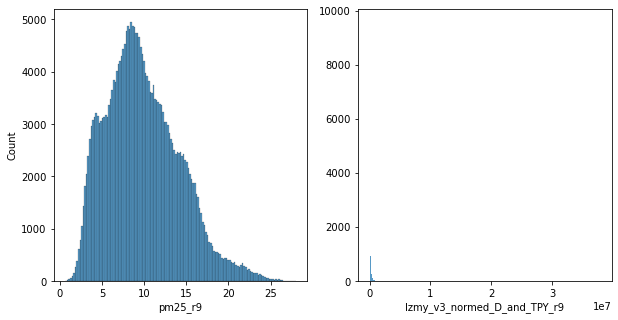

In [29]:
#columns = ['pm25', 'avg_wind_alignment_cosine'] # hardcoded previously but made dynamically
columns = [target_name_s1, predictor_name_s1]


# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all_iv_filtered[columns[idx]],
            ax=ax
        )
    
    if idx in [0]:
        ax.set_ylabel('Count')
    else:
        ax.set_ylabel(' ')

``health outcomes``

In [30]:
print(y_col_names)

['y_visits_all_malignant_cancers', 'y_visits_all_nonblood_malignant_cancers', 'y_visits_blood_diseases', 'y_visits_blood_or_bv_diseases', 'y_visits_blood_vessel_diseases', 'y_visits_cardioresp_cancers', 'y_visits_hematopoietic_cancers', 'y_visits_injuries', 'y_visits_respiratory', 'y_visits_type_1_diabetes']


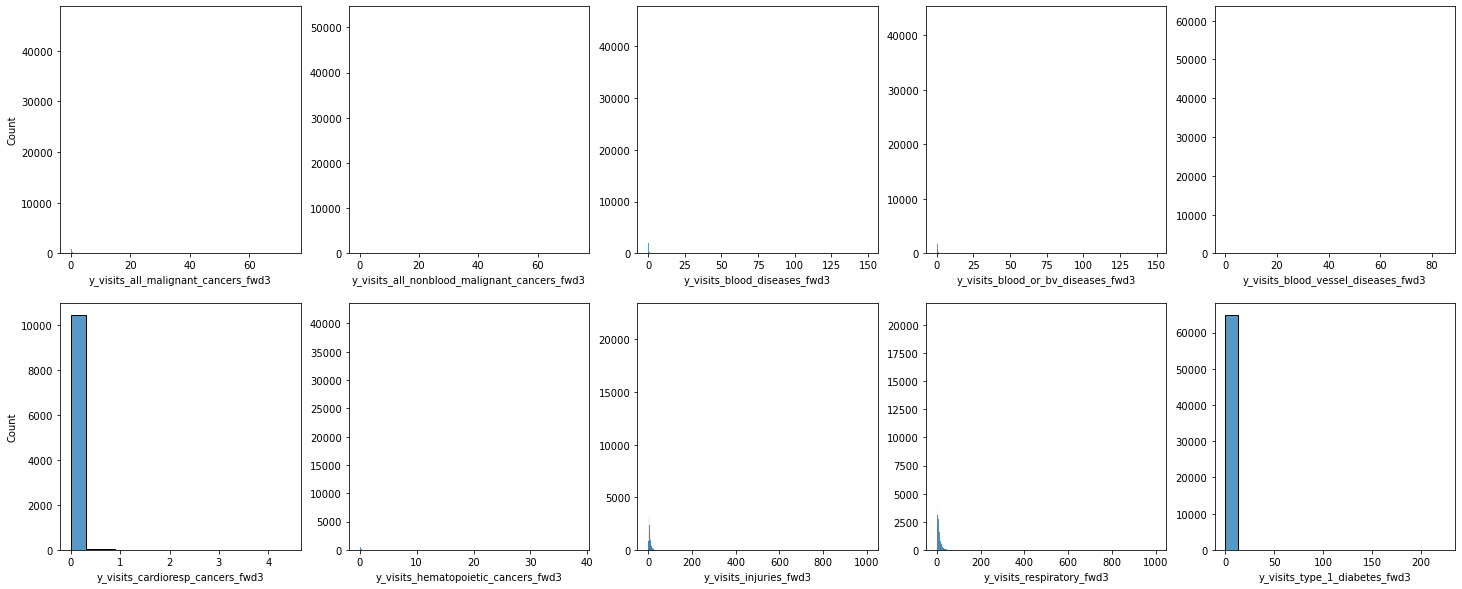

In [31]:
#columns = df_h.columns[1:]
columns = y_col_names_lag

# compute visits by patzip_year_month
fig, axes = plt.subplots(int(len(columns)/5), 5, sharex=False, sharey=False, figsize=(25, int(len(columns))))

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all_iv_filtered[columns[idx]],
            ax=ax
        )
    if idx in [0, 5]:
        ax.set_ylabel('Count')
    else:
        ax.set_ylabel(' ')

In [32]:
# columns = y_col_names_lag_diff

# # compute visits by patzip_year_month
# fig, axes = plt.subplots(int(len(columns)/5), 5, sharex=False, sharey=False, figsize=(25, int(len(columns))))

# for idx, ax in enumerate(axes.flatten()):
#     sb.histplot(
#             df_all_iv_filtered[columns[idx]],
#             ax=ax
#         )
#     if idx in [0, 5]:
#         ax.set_ylabel('Count')
#     else:
#         ax.set_ylabel(' ')

---
### Step 7: Analysis - linear modeling

#### 7.1. Check outcome_hat columns
* Make sure that the format contains the lag

In [33]:
# verify names of columns + lag we're going to use
print("y_col_names_lag:\n{}".format(y_col_names_lag))
print("y_col_names_lag_diff:\n{}".format(y_col_names_lag_diff))


y_col_names_lag:
['y_visits_all_malignant_cancers_fwd3', 'y_visits_all_nonblood_malignant_cancers_fwd3', 'y_visits_blood_diseases_fwd3', 'y_visits_blood_or_bv_diseases_fwd3', 'y_visits_blood_vessel_diseases_fwd3', 'y_visits_cardioresp_cancers_fwd3', 'y_visits_hematopoietic_cancers_fwd3', 'y_visits_injuries_fwd3', 'y_visits_respiratory_fwd3', 'y_visits_type_1_diabetes_fwd3']
y_col_names_lag_diff:
['y_visits_all_malignant_cancers_fwd3_diff_r12', 'y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12', 'y_visits_blood_diseases_fwd3_diff_r12', 'y_visits_blood_or_bv_diseases_fwd3_diff_r12', 'y_visits_blood_vessel_diseases_fwd3_diff_r12', 'y_visits_cardioresp_cancers_fwd3_diff_r12', 'y_visits_hematopoietic_cancers_fwd3_diff_r12', 'y_visits_injuries_fwd3_diff_r12', 'y_visits_respiratory_fwd3_diff_r12', 'y_visits_type_1_diabetes_fwd3_diff_r12']


#### 7.2. ``fit ols``

In [34]:
for col in y_col_names_lag:
    fit_ols(df_all_iv_filtered, col, target_name_s1, fixed_effects)

Outcome:  y_visits_all_malignant_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.000521,0.002475,-0.005496,0.004453,0.834054
1,Intercept,0.218368,0.082265,0.053050,0.383686,0.010683


Outcome:  y_visits_all_nonblood_malignant_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.000512,0.002422,-0.005383,0.004359,0.833457
1,Intercept,0.116722,0.051770,0.012632,0.220813,0.028756


Outcome:  y_visits_blood_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.006236,0.003361,-0.000518,0.012990,0.069532
1,Intercept,-0.003008,0.057378,-0.118313,0.112298,0.958410


Outcome:  y_visits_blood_or_bv_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.005411,0.002983,-0.000580,0.011401,0.075666
1,Intercept,-0.030802,0.049174,-0.129571,0.067968,0.533916


Outcome:  y_visits_blood_vessel_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.001910,0.000820,-0.003559,-0.000260,0.024172
1,Intercept,0.000574,0.030133,-0.060013,0.061161,0.984884


Outcome:  y_visits_cardioresp_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.002191,0.001035,-0.004311,-0.000071,0.043252
1,Intercept,0.014868,0.017901,-0.021800,0.051536,0.413240


Outcome:  y_visits_hematopoietic_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.001534,0.002173,-0.005902,0.002834,0.483477
1,Intercept,0.250050,0.091750,0.065574,0.434526,0.008938


Outcome:  y_visits_injuries_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.049300,0.034904,-0.119372,0.020772,0.163889
1,Intercept,-3.999124,1.182980,-6.374055,-1.624193,0.001395


Outcome:  y_visits_respiratory_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.091291,0.08286,-0.257640,0.075057,0.275741
1,Intercept,-5.804858,1.74709,-9.312288,-2.297428,0.001655


Outcome:  y_visits_type_1_diabetes_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.002209,0.006354,-0.010567,0.014985,0.729643
1,Intercept,-0.249281,0.326675,-0.906105,0.407543,0.449147


In [35]:
for col in y_col_names_lag_diff:
    fit_ols(df_all_iv_filtered, col, target_name_s1, fixed_effects)

Outcome:  y_visits_all_malignant_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.005564,0.004065,-0.002605,0.013732,0.177308
1,Intercept,-0.134479,0.081740,-0.298742,0.029783,0.106328


Outcome:  y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.003189,0.001967,-0.000766,0.007145,0.111547
1,Intercept,-0.115268,0.052010,-0.219841,-0.010695,0.031447


Outcome:  y_visits_blood_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.002187,0.002325,-0.002488,0.006861,0.351666
1,Intercept,0.072380,0.051662,-0.031493,0.176254,0.167634


Outcome:  y_visits_blood_or_bv_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.002611,0.002411,-0.002233,0.007455,0.284064
1,Intercept,-0.000424,0.048224,-0.097334,0.096486,0.993019


Outcome:  y_visits_blood_vessel_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.001137,0.001103,-0.001080,0.003354,0.307452
1,Intercept,-0.057388,0.028663,-0.115018,0.000243,0.050937


Outcome:  y_visits_cardioresp_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.000881,0.000819,-0.000799,0.002561,0.291622
1,Intercept,0.020002,0.012815,-0.006292,0.046296,0.130211


Outcome:  y_visits_hematopoietic_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.003479,0.002679,-0.001907,0.008864,0.200270
1,Intercept,-0.204806,0.084365,-0.374433,-0.035178,0.018999


Outcome:  y_visits_injuries_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,0.005021,0.026063,-0.047302,0.057345,0.847988
1,Intercept,-1.424548,0.774520,-2.979461,0.130366,0.071701


Outcome:  y_visits_respiratory_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.060847,0.024039,-0.109107,-0.012586,0.014495
1,Intercept,1.397992,0.540060,0.313776,2.482207,0.012526


Outcome:  y_visits_type_1_diabetes_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9,-0.004709,0.005297,-0.015360,0.005941,0.378425
1,Intercept,0.156951,0.282822,-0.411701,0.725604,0.581509


#### 7.3. ``fit Stage 1``
* The function `fit_1st_stage` is in "Step 3: Define functions" in this notebook; added functionality within that function to output the model object in .pkl form to the directory called models_s1/

In [36]:
df_all_iv_filtered = fit_1st_stage(df_all_iv_filtered, target_name_s1, predictor_name_s1, fixed_effects)


Outcome:  pm25_r9
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,Izmy_v3_normed_D_and_TPY_r9,-3.485359e-07,9.846839e-08,-5.457155e-07,-1.513564e-07,8.057818e-04
1,Intercept,8.844315e+00,1.441276e+00,5.958209e+00,1.173042e+01,8.589035e-08


In [37]:
display(df_all_iv_filtered[[target_name_s1, target_name_s1 + '_hat']])

,pm25_r9,pm25_r9_hat
24,21.916667,19.607199
25,22.851852,20.227607
26,23.625926,19.992042
27,23.583333,19.895238
28,23.418518,19.316006
...,...,...
294892,2.942708,3.359011
294893,3.102431,3.501744
294894,3.113194,3.579745
294895,3.397917,3.674647


#### 7.4. Save Stage 1 dataset (csv + parquet)
Don't worry, Cornelia, these datasets only contain our own features and predictions - we dropped your true health data columns earlier!

In [38]:
# Drops all health-data-related columns before saving
saved_stage1 = df_all_iv_filtered.drop(columns=[i for i in df_all_iv_filtered.columns if 'visit' in i])

In [39]:
# Check that there are no longer any health-data-related columns in the dataset (should return empty list)
[i for i in saved_stage1.columns if 'visit' in i]

[]

In [40]:
# Saving out datasets
saved_stage1_name = "s1_" + notebook_index + "_PREDICTOR_" + predictor_name_s1 +  "_FE_SET_" + str(FE_set_num) + "_TARGETING_" + target_name_s1 + "_LAG" + HO_lag_input
saved_stage1.to_csv(os.path.join(out_dir1, saved_stage1_name + ".csv"))
saved_stage1.to_parquet(os.path.join(out_dir1, saved_stage1_name + ".parquet"))

#### 7.5. Plot counts per pm2.5r# and pm2.5r#_hat

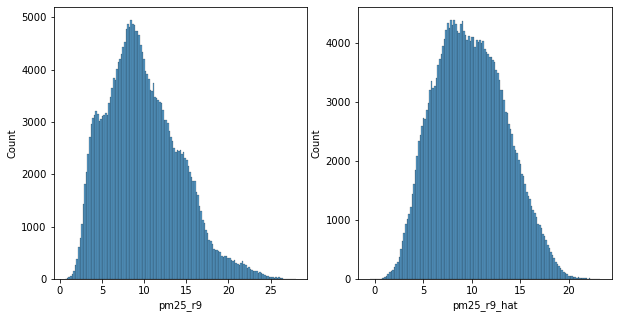

In [41]:
columns = [target_name_s1, target_name_s1+'_hat']

# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all_iv_filtered[columns[idx]],
            ax=ax
        )

#### 7.6. Stage 1 F-test:

Run an F test with our instrument to study the impact on the pm2.5. 

In [42]:
# get data into right model form

y, X_null = dmatrices(f'{target_name_s1} ~ 1', data=df_all_iv_filtered, return_type='dataframe')
y, X_instrument = dmatrices(f'{target_name_s1} ~ 1 + {predictor_name_s1}', data=df_all_iv_filtered, return_type='dataframe')

fit_null = sm.OLS(y, X_null).fit()
fit_instrument = sm.OLS(y, X_instrument).fit()

anovaResults = anova_lm(fit_null, fit_instrument)
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,262449.0,4.934512e+06,0.0,NaN,NaN,NaN
1,262448.0,4.911781e+06,1.0,22731.204524,1214.581705,1.681578e-265


#### 7.7. ``fit 2sls``
* Fits the stage 2 linear regression
* The function `2sls` is in "Step 3: Define functions" in this notebook; added functionality within that function to output the model object in .pkl form to the directory called models_s2/
* Generates dataset after dropping the real health outcomes values (so we're only saving the predicted values)

In [43]:
list_of_stage2_saves = []
saved_stage1_copy = df_all_iv_filtered.drop(columns=[i for i in df_all_iv_filtered.columns if 'visit' in i])

# Merging predicted outcome variables (taken from subsetting the fit_2sls function output dataset) with original dataset (minus visits columns)
for col in y_col_names_lag:
    s2_df = fit_2sls(df_all_iv_filtered, col, target_name_s1+"_hat", fixed_effects)
    
    # subset to have join keys and new columns (e.g. 'y_visits_hematopoietic_cancers_fwd3_hat') only
    outcome_hat = s2_df[['year_month', 'school_zip', col+"_hat"]]
    saved_stage1_copy = pd.merge(saved_stage1_copy, outcome_hat, how='left', left_on=['year_month', 'school_zip'], right_on=['year_month', 'school_zip'])
    rmse_val = np.mean(((df_all_iv_filtered[col] - saved_stage1_copy[col+'_hat'])**2)**.5)
    print('RMSE for {} and {}: {}'.format(col, col+'_hat', rmse_val))



Outcome:  y_visits_all_malignant_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.048444,0.241715,-0.534189,0.437302,0.841984
1,Intercept,0.641359,2.152687,-3.684628,4.967345,0.767013


RMSE for y_visits_all_malignant_cancers_fwd3 and y_visits_all_malignant_cancers_fwd3_hat: 0.3022023251199594
Outcome:  y_visits_all_nonblood_malignant_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.153264,0.228911,-0.613520,0.306992,0.506362
1,Intercept,1.466982,2.046645,-2.648074,5.582038,0.476987


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_all_nonblood_malignant_cancers_fwd3 and y_visits_all_nonblood_malignant_cancers_fwd3_hat: 0.19590089336746014
Outcome:  y_visits_blood_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.050035,0.089671,-0.230235,0.130164,0.579391
1,Intercept,0.502348,0.791804,-1.088840,2.093537,0.528748


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_blood_diseases_fwd3 and y_visits_blood_diseases_fwd3_hat: 0.37899399086653734
Outcome:  y_visits_blood_or_bv_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.002942,0.098325,-0.200433,0.194549,0.976246
1,Intercept,0.048352,0.880065,-1.719311,1.816015,0.956404


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_blood_or_bv_diseases_fwd3 and y_visits_blood_or_bv_diseases_fwd3_hat: 0.4532253899234362
Outcome:  y_visits_blood_vessel_diseases_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.006128,0.092497,-0.192105,0.179849,0.947452
1,Intercept,0.035915,0.829725,-1.632359,1.704189,0.965654


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_blood_vessel_diseases_fwd3 and y_visits_blood_vessel_diseases_fwd3_hat: 0.12675531249579197
Outcome:  y_visits_cardioresp_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.046094,0.037821,-0.031378,0.123566,0.233110
1,Intercept,-0.410477,0.343943,-1.115013,0.294059,0.242709


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_cardioresp_cancers_fwd3 and y_visits_cardioresp_cancers_fwd3_hat: 0.029422588639707363
Outcome:  y_visits_hematopoietic_cancers_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.055983,0.082348,-0.109588,0.221554,0.499873
1,Intercept,-0.258920,0.753154,-1.773238,1.255397,0.732512


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_hematopoietic_cancers_fwd3 and y_visits_hematopoietic_cancers_fwd3_hat: 0.19237405752339407
Outcome:  y_visits_injuries_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.255590,0.807994,-1.366525,1.877706,0.753045
1,Intercept,-6.722078,7.330406,-21.438483,7.994327,0.363452


RMSE for y_visits_injuries_fwd3 and y_visits_injuries_fwd3_hat: 6.070910251815726
Outcome:  y_visits_respiratory_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.480488,0.762289,-2.010847,1.049871,0.531298
1,Intercept,-2.377218,6.755729,-15.939911,11.185474,0.726377


RMSE for y_visits_respiratory_fwd3 and y_visits_respiratory_fwd3_hat: 8.572116917723012
Outcome:  y_visits_type_1_diabetes_fwd3
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.096482,0.092638,-0.089780,0.282744,0.302864
1,Intercept,-1.078970,0.938683,-2.966319,0.808379,0.256065


RMSE for y_visits_type_1_diabetes_fwd3 and y_visits_type_1_diabetes_fwd3_hat: 0.150919611153066


In [44]:
# Repeat using y_col_names_lag_diff
for col in y_col_names_lag_diff:
    s2_df = fit_2sls(df_all_iv_filtered, col, target_name_s1+"_hat", fixed_effects)
    
    # subset to have join keys and new columns (e.g. 'y_visits_hematopoietic_cancers_fwd3_hat') only
    outcome_hat = s2_df[['year_month', 'school_zip', col, col+"_hat"]]
    saved_stage1_copy = pd.merge(saved_stage1_copy, outcome_hat, how='left', left_on=['year_month', 'school_zip'], right_on=['year_month', 'school_zip'])
    rmse_val = np.mean(((df_all_iv_filtered[col] - saved_stage1_copy[col+'_hat'])**2)**.5)
    print('RMSE for {} and {}: {}'.format(col, col+'_hat', rmse_val))

Outcome:  y_visits_all_malignant_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.027069,0.142890,-0.260078,0.314217,0.850528
1,Intercept,-0.319520,1.280661,-2.893104,2.254063,0.804020


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_all_malignant_cancers_fwd3_diff_r12 and y_visits_all_malignant_cancers_fwd3_diff_r12_hat: 0.3158214424044917
Outcome:  y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.038085,0.137033,-0.237437,0.313608,0.782261
1,Intercept,-0.419110,1.233049,-2.898321,2.060100,0.735417


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12 and y_visits_all_nonblood_malignant_cancers_fwd3_diff_r12_hat: 0.2101397586514308
Outcome:  y_visits_blood_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.102896,0.030731,-0.164685,-0.041107,0.001589
1,Intercept,1.006292,0.263186,0.477121,1.535464,0.000379


RMSE for y_visits_blood_diseases_fwd3_diff_r12 and y_visits_blood_diseases_fwd3_diff_r12_hat: 0.3647917048982195
Outcome:  y_visits_blood_or_bv_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.134257,0.053085,-0.240935,-0.027579,0.014704
1,Intercept,1.215340,0.460997,0.288932,2.141748,0.011194


RMSE for y_visits_blood_or_bv_diseases_fwd3_diff_r12 and y_visits_blood_or_bv_diseases_fwd3_diff_r12_hat: 0.4206850263799251
Outcome:  y_visits_blood_vessel_diseases_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.025966,0.099358,-0.225739,0.173807,0.794953
1,Intercept,0.183984,0.865780,-1.556783,1.924751,0.832611


RMSE for y_visits_blood_vessel_diseases_fwd3_diff_r12 and y_visits_blood_vessel_diseases_fwd3_diff_r12_hat: 0.12544850699644716
Outcome:  y_visits_cardioresp_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,0.002413,0.047190,-0.094413,0.09924,0.959593
1,Intercept,0.005188,0.420133,-0.856853,0.86723,0.990238


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_cardioresp_cancers_fwd3_diff_r12 and y_visits_cardioresp_cancers_fwd3_diff_r12_hat: 0.03995707042725997
Outcome:  y_visits_hematopoietic_cancers_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.039832,0.049736,-0.139832,0.060168,0.427153
1,Intercept,0.179831,0.454734,-0.734474,1.094135,0.694253


C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\regression\_prediction.py:61: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


RMSE for y_visits_hematopoietic_cancers_fwd3_diff_r12 and y_visits_hematopoietic_cancers_fwd3_diff_r12_hat: 0.20395965487758055
Outcome:  y_visits_injuries_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.047599,0.252993,-0.555504,0.460307,0.851511
1,Intercept,-0.954397,2.227662,-5.426615,3.517821,0.670142


RMSE for y_visits_injuries_fwd3_diff_r12 and y_visits_injuries_fwd3_diff_r12_hat: 3.1982926793704367
Outcome:  y_visits_respiratory_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-1.802568,0.294184,-2.393166,-1.211969,1.294898e-07
1,Intercept,16.823961,2.768334,11.266298,22.381624,1.551763e-07


RMSE for y_visits_respiratory_fwd3_diff_r12 and y_visits_respiratory_fwd3_diff_r12_hat: 4.184128391341871
Outcome:  y_visits_type_1_diabetes_fwd3_diff_r12
-------------------------------------


,variable,coef,std err,[0.025,0.975],p-value
0,pm25_r9_hat,-0.020178,0.098374,-0.217972,0.177617,0.838352
1,Intercept,0.288714,1.053815,-1.830123,2.407551,0.785283


RMSE for y_visits_type_1_diabetes_fwd3_diff_r12 and y_visits_type_1_diabetes_fwd3_diff_r12_hat: 0.146928629824306


#### 7.8. Save Stage 2 dataset
* Contains: all pm2.5r#, pm2.5r#_hat, outcome_hats, all instruments

In [45]:
# saves stage 2 datasets (minus any visits columns) as csv and parquet

s2_dataset_out_name = "s2_" + notebook_index + "_INSTRUMENT_" + predictor_name_s1 + "_FE_SET_" + str(FE_set_num) + "_TARGETING_" + "all_outcomes" + "_LAG" + HO_lag_input
saved_stage1_copy.to_csv(os.path.join(out_dir2, s2_dataset_out_name + ".csv"))
saved_stage1_copy.to_parquet(os.path.join(out_dir2, s2_dataset_out_name + ".parquet"))

#### 7.9. Generate dataset with name of the notebook, the stage 1 and stage 2 model and corresponding fixed effects (csv)
* Generates a csv that associates an instrument-plus-fixed-effects combo with the filenames of S1 and S2 datasets that we wrote out (doesn't include any columns with real outcome/visit data)

In [46]:
csv_name = 'fixed_effects_' + notebook_index + '.csv'
FE_df_data = [[notebook_index, predictor, fixed_effects, saved_stage1_name+'.csv', s2_dataset_out_name+'.csv']]
FE_df = pd.DataFrame(data=FE_df_data, columns=['notebook_idx', 'instrument_name', 'fixed_effects_list', 's1_filename', 's2_filename'])
display(FE_df)

,notebook_idx,instrument_name,fixed_effects_list,s1_filename,s2_filename
0,diff04_fn_T,Izmy_v3_normed_D_and_TPY,~ county + month + year_trend * C(county_mont...,s1_diff04_fn_T_PREDICTOR_Izmy_v3_normed_D_and_...,s2_diff04_fn_T_INSTRUMENT_Izmy_v3_normed_D_and...


In [47]:
# Write out to csv
FE_df.to_csv(os.path.join(out_dir3, csv_name))